<a href="https://colab.research.google.com/github/edgarbarr1/colon-cancer-cnn/blob/main/colon_cancer_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colon Cancer #
### _Predicting the outcomes of colon cells to predict cancer_ ###

### Business Understanding ###
Colon cancer has been deemed the number 3 most common cancer in the world, according to the World Cancer Research Fund. Based on this statistic, it is not a surprise to know that more approximately 19 million colonoscopies are perfeormed each year in the United States.

Some experts believe that some of the main causes of this cancer is the Western food diet along with living a sedentary lifestyle as well as being obese. Unfortunately, according to the CDC, the US appears to be on an upward trend in obesity which in turn increses the likelihood of men and women to develop colorectal cancers.

Although the morttality rate for the most part appears to be relatively low (80% survival rate), it is important to note that like everything, there is always something to improve with either accurate test results, the time it takes to report those results and the resources available to compile said results.

Currently, as per the American Cancer Society, it takes 2-3 days to report the findings of a colonoscopy biopsy.

Objective
This notebook has the objective of finding out the population that is deeply affected by colon cancer and build a Convolutional Neural Network that can get close to the 1-2% accuracy that current tests. We will also strive to have an efficient model that can give accurate results faster than 2-3 days and ideally within the time frame of "same-day" results.

Before doing so, we will look at some mortality rates among different populations and determine whether the economic status of a population affects the mortality rate of colon cancer.



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random

import PIL
import PIL.Image
import pathlib
# Packages to import and preprocess images
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Packages for our models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(tf.__version__)

2.5.0


Deleted all folders from zenodo except NORM which is normal and TUM which is the cancer cells

Inspiration for the function in the creation of the [directories](https://www.youtube.com/watch?v=_L2uYfVV48I)

In order to have class balance in the dataset we will be using a total of 24,000 images for our model training, 1,800 items for the validation, and 1,720 images for our test dataset to generate predictions. This brings our total of images used to 27,520 images used in this Convolutional Neural Network.

In [4]:
# PIL.Image.open('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/NORM-AAAKGLVQ.tif')

In [5]:
# os.listdir()

In [6]:
# normal_image_count = len(list(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/*.tif')))
# cancer_image_count = len(list(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM/*.tif')))
# print('Normal images: {}'.format(normal_image_count))
# print('Cancer images: {}'.format(cancer_image_count))

The images in the dataset are in TIF format. Let's convert the images into jpegs.

In [12]:
# ell to convert the TIF images to jpeg

# paths = ['/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM',
#          '/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM']
# for path in paths:
#   for root, dirs, files in os.walk(path, topdown=False,):
#       for name in files:
#           print(os.path.join(root, name))
#           #if os.path.splitext(os.path.join(root, name))[1].lower() == ".tiff":
#           if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
#               if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
#                   print ("A jpeg file already exists for %s" % name)
#               # If a jpeg with the name does *NOT* exist, convert one from the tif.
#               else:
#                   outputfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
#                   try:
#                       im = PIL.Image.open(os.path.join(root, name))
#                       print ("Converting jpeg for %s" % name)
#                       im.thumbnail(im.size)
#                       im.save(outputfile, "JPEG", quality=100)
#                   except Exception as e: 
#                     print(e)

# Jpegs have been converted. Now separate into subdirectories.

Now let's divide the images into subdirecotiries.

In [13]:
# os.chdir('drive/MyDrive/colon_dataset')

In [14]:
# os.listdir()

In [15]:
# Makes the subdirecoteries for the training, validation, and testing data.
# if os.path.isdir('train/normal') is False:
#     os.makedirs('train/normal')
#     os.makedirs('train/cancer')
#     os.makedirs('validation/normal')
#     os.makedirs('validation/cancer')
#     os.makedirs('test/')

Currently we have Tif and jpeg duplicates in our directory. Now we will move the jpeg images to the newly created directories.

In [16]:
# Run this code to move the images from the original dataset directory to the newly created dataset that the model will read.
# for image in random.sample(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/*.jpg'), 8000):
#   shutil.move(image, '/content/drive/MyDrive/colon_dataset/train/normal/')


# for image in random.sample(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM/*.jpg'), 8000):
#   shutil.move(image, '/content/drive/MyDrive/colon_dataset/train/cancer/')


# for image in random.sample(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/*.jpg'), 400):
#   shutil.move(image, '/content/drive/MyDrive/colon_dataset/validation/normal/')


# for image in random.sample(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM/*.jpg'), 400):
#   shutil.move(image, '/content/drive/MyDrive/colon_dataset/validation/cancer/')


# for image in random.sample(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/*.jpg'), 360):
#   shutil.move(image, '/content/drive/MyDrive/colon_dataset/test/')


# for image in random.sample(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM/*.jpg'), 360):
#   shutil.move(image, '/content/drive/MyDrive/colon_dataset/test/')

In [17]:
# current_path_list = ['/content/drive/MyDrive/colon_dataset/validation',
#                      '/content/drive/MyDrive/colon_dataset/test',
#                      '/content/drive/MyDrive/colon_dataset/train']

# Image Data Generator #

In [18]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = (0.95,0.95),
    brightness_range = [0.5, 1.0]
)

In [19]:
train_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/train',
    target_size = (224,224),
    batch_size = 20,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    subset = 'training',
    seed = 20
)
validation_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/validation',
    target_size = (224,224),
    batch_size = 20,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    subset = 'training',
    seed = 20
)

Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Model 1 #

Let's create our first model based on the data generator that we created above.

Our first model will be a rather simple one with the following layers:




1.   A convolutional layer with a (10,10) kernel size or the height and width of our convolutional window.
2.   A Max Pooling Layer that with a height and width of (5,5).
1.   A Dense Layer with a 64 output size
2.  










In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), activation='relu' , input_shape = (224,224,3)))
model.add(MaxPooling2D(3,3))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 73, 73, 64)        2112      
_________________________________________________________________
flatten (Flatten)            (None, 341056)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 341057    
Total params: 345,601
Trainable params: 345,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dropout
import seaborn as sns

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

In [24]:
history = model.fit(x= train_generator,
                    validation_data = validation_generator,
                    epochs = 5)

Epoch 1/5
800/800 [==============================] - 7794s 10s/step - loss: 0.5910 - precision: 0.7202 - recall: 0.7139 - val_loss: 0.4249 - val_precision: 0.7925 - val_recall: 0.8975
Epoch 2/5
800/800 [==============================] - 219s 273ms/step - loss: 0.4151 - precision: 0.8227 - recall: 0.8225 - val_loss: 0.4722 - val_precision: 0.8367 - val_recall: 0.7300
Epoch 3/5
800/800 [==============================] - 219s 274ms/step - loss: 0.3747 - precision: 0.8395 - recall: 0.8454 - val_loss: 0.4890 - val_precision: 0.7323 - val_recall: 0.9575
Epoch 4/5
800/800 [==============================] - 220s 275ms/step - loss: 0.3293 - precision: 0.8658 - recall: 0.8622 - val_loss: 0.3185 - val_precision: 0.9056 - val_recall: 0.8150
Epoch 5/5
800/800 [==============================] - 218s 272ms/step - loss: 0.2812 - precision: 0.8865 - recall: 0.8855 - val_loss: 0.5241 - val_precision: 0.6840 - val_recall: 0.9850


In [25]:
preds_train_1 = model.predict(train_generator)
preds_val_1 = model.predict(validation_generator)

40/40 [==============================] - 6s 127ms/step


In [26]:
model_metrics = model.evaluate(validation_generator)
model_metrics

40/40 [==============================] - 11s 269ms/step - loss: 0.5227 - precision: 0.6747 - recall: 0.9850


[0.5226746797561646, 0.6746575236320496, 0.9850000143051147]

In [27]:
perf_df = pd.DataFrame(columns=['model', 'loss', 'precision', 'recall'])
perf_df.loc[len(perf_df.index)] = ['model'] + model_metrics

In [28]:
perf_df

,model,loss,precision,recall
0,model,0.522675,0.674658,0.985


In [29]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred,)
    
    ax= plt.subplot()
    # annot=True to annotate cells, fmt='g' to disable scientific notation
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='magma', linewidths=1, linecolor='black')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    plt.show();

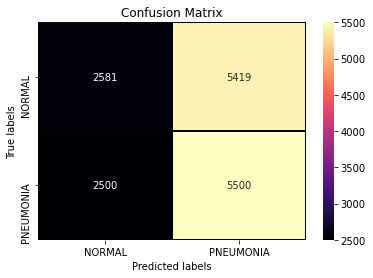

In [30]:
plot_confusion_matrix(train_generator.labels, np.rint(preds_train_1))

In [31]:
def visualize_training_results_1(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall'])
    ax1.plot(history.history['val_recall'])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    pass

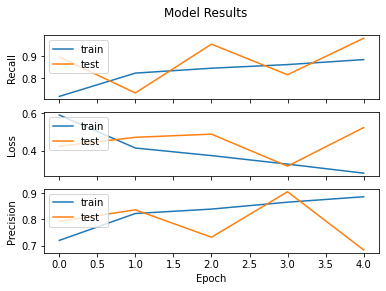

In [32]:
visualize_training_results_1(history)

# Model 2 #

In [33]:
model_2 = Sequential()
model_2.add(Conv2D(16, kernel_size=(5,5), padding='valid', input_shape = (224,224,3)))
model_2.add(MaxPooling2D(3,3))
model_2.add(Dense(32, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(LeakyReLU(alpha=(.3)))
model_2.add(Dropout(.20))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [34]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 73, 73, 32)        544       
_________________________________________________________________
flatten_1 (Flatten)          (None, 170528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               21827712  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [35]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

In [36]:
model_2.fit(
    x = train_generator,
    validation_data = validation_generator,
    batch_size = 20,
    epochs = 10
)

Epoch 1/10
800/800 [==============================] - 217s 270ms/step - loss: 0.6988 - precision_1: 0.5862 - recall_1: 0.5249 - val_loss: 0.6376 - val_precision_1: 0.7606 - val_recall_1: 0.4925
Epoch 2/10
800/800 [==============================] - 219s 274ms/step - loss: 0.6382 - precision_1: 0.6699 - recall_1: 0.6100 - val_loss: 0.5055 - val_precision_1: 0.8401 - val_recall_1: 0.7750
Epoch 3/10
800/800 [==============================] - 216s 270ms/step - loss: 0.5281 - precision_1: 0.7661 - recall_1: 0.7475 - val_loss: 0.5396 - val_precision_1: 0.7714 - val_recall_1: 0.6750
Epoch 4/10
800/800 [==============================] - 215s 269ms/step - loss: 0.4116 - precision_1: 0.8289 - recall_1: 0.8171 - val_loss: 0.4151 - val_precision_1: 0.8779 - val_recall_1: 0.7550
Epoch 5/10
800/800 [==============================] - 215s 269ms/step - loss: 0.2966 - precision_1: 0.8755 - recall_1: 0.8892 - val_loss: 0.4055 - val_precision_1: 0.8438 - val_recall_1: 0.8375
Epoch 6/10
800/800 [==========

In [37]:
preds_train_2 = model_2.predict(train_generator)
preds_val_2 = model_2.predict(validation_generator)

In [38]:
model_metrics = model_2.evaluate(validation_generator)
model_metrics

40/40 [==============================] - 11s 267ms/step - loss: 0.6756 - precision_1: 0.8693 - recall_1: 0.7150


[0.675639271736145, 0.869300901889801, 0.7149999737739563]

In [39]:
perf_df = pd.DataFrame(columns=['model', 'loss', 'precision', 'recall'])
perf_df.loc[len(perf_df.index)] = ['model'] + model_metrics

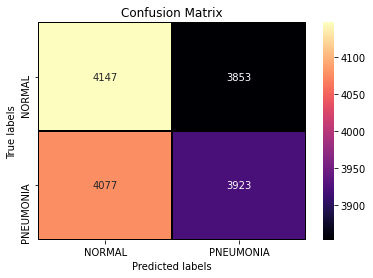

In [40]:
plot_confusion_matrix(train_generator.labels, np.rint(preds_train_2))

In [42]:
def visualize_training_results(history, iteration):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall_{}'.format(iteration)])
    ax1.plot(history.history['val_recall_{}'.format(iteration)])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision_{}'.format(iteration)])
    ax3.plot(history.history['val_precision_{}'.format(iteration)])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    pass

KeyError: ignored

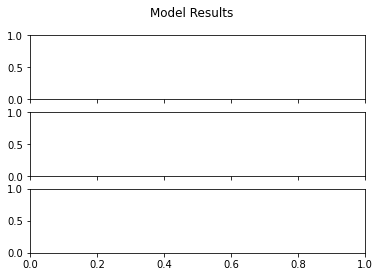

In [47]:
visualize_training_results(model_2.history, 1)

# Model 3 #

In [48]:
model_3 = Sequential()
model_3.add(Conv2D(256, kernel_size=(10,10), activation='relu', input_shape = (224,224,3)))
model_3.add(MaxPooling2D(7,7))
model_3.add(Dense(256, activation='relu'))
model_3.add(Conv2D(128, kernel_size=(7,7), activation='relu'))
model_3.add(MaxPooling2D(5,5))
model_3.add(Dense(64))
model_3.add(Flatten())
model_3.add(Dropout(.15))
model_3.add(Dense(512,activation='relu'))
model_3.add(LeakyReLU(alpha=.2))
model_3.add(Dropout(.15))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

In [49]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 215, 215, 256)     77056     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
dense_6 (Dense)              (None, 30, 30, 256)       65792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1605760   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dense_7 (Dense)              (None, 4, 4, 64)          8256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)             

In [50]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

In [51]:
model_3.fit(x=train_generator,
            validation_data = validation_generator,
            epochs=10)

Epoch 1/10
800/800 [==============================] - 223s 277ms/step - loss: 0.6945 - precision_2: 0.4965 - recall_2: 0.3506 - val_loss: 0.6932 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
800/800 [==============================] - 221s 276ms/step - loss: 0.6934 - precision_2: 0.5008 - recall_2: 0.3325 - val_loss: 0.6934 - val_precision_2: 0.5000 - val_recall_2: 1.0000
Epoch 3/10
800/800 [==============================] - 220s 275ms/step - loss: 0.6935 - precision_2: 0.4923 - recall_2: 0.5437 - val_loss: 0.6932 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
800/800 [==============================] - 220s 276ms/step - loss: 0.6932 - precision_2: 0.5056 - recall_2: 0.4755 - val_loss: 0.6933 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/10
800/800 [==============================] - 221s 276ms/step - loss: 0.6932 - precision_2: 0.5013 - recall_2: 0.3501 - val_loss: 0.6932 - val_precision_2: 0.5000 - val_recall_2: 1.0000
Epoch 

As per the documentation of the dataset it appears that the images in the zenodo dataset are 224x224 pixels. The dataset in the kaggle dataset are 768x768. IN this case we will make the 224x224 size standard accross all images.